Optimization terminated successfully.
         Current function value: 0.475484
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   60
Model:                          Logit   Df Residuals:                       58
Method:                           MLE   Df Model:                            1
Date:                Wed, 22 May 2024   Pseudo R-squ.:                  0.3140
Time:                        14:46:54   Log-Likelihood:                -28.529
converged:                       True   LL-Null:                       -41.587
Covariance Type:            nonrobust   LLR p-value:                 3.214e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0246      0.296      0.083      0.934      -0.556       0.605
V              1.3344      0.

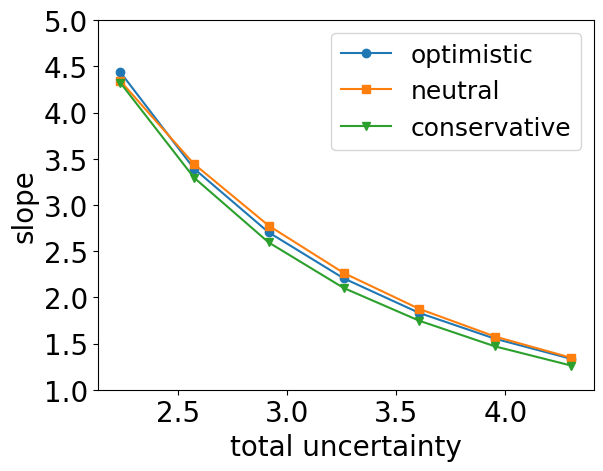

In [1]:

import pandas as pd
import numpy as np
from statsmodels.discrete.discrete_model import Probit
from statsmodels.discrete.discrete_model import  Logit
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sn
plt.style.use('default')

def standardization(data):
    data = np.array(data)
    mu = np.mean(data, axis=0)
    print(mu)
    sigma = np.std(data, axis=0)
    print(sigma)
    return (data ) / (sigma + 1e-9)


def plot_logit(w=None, b=None, label=None):
    x = np.arange(-1.5,1.5,0.05)
    y = 1. / (1+np.exp(-(x*w + b)))
    plt.plot(x, y, label=label)

if __name__ == '__main__':
    
    RU = 1
    r1_std_list = [3.5,3.25,3,2.75,2.5,2.25,2]
    n = len(r1_std_list)
    modes = ['seeking', 'neutral', 'averse']
    labels = ['optimistic', 'neutral','conservative']
    fmts = ['o-', 's-', 'v-']
    for (i,mode) in enumerate(modes):
        b_list = []
        b_std_list = []
        w_list = []
        w_std_list = []
        TU_list = []
        for (index, r1_std) in enumerate(r1_std_list):
            r2_std = r1_std - RU
            TU = np.sqrt(r1_std **2 + r2_std ** 2)
            p_list_combined = []
            for times in range(10):
                p_list = np.load(f'saved/simulation_RU={RU}_std={r1_std}_{mode}_{times}_n=2.npy')
                p_list = p_list[np.newaxis, :]
                if times == 0:
                    p_list_combined = p_list
                else:
                    p_list_combined = np.concatenate([p_list_combined, p_list], axis=0)
            p_mean = np.mean(p_list_combined, axis=0)
            p_std = np.std(p_list_combined, axis=0)

            V_list = np.arange(-1.5, 1.5, 0.05)
            # V_list = standardization(V_list)
            # sn.distplot(np.array(V_list),bins=100)
            # plt.show()
            X = np.array(V_list).T
            X = pd.DataFrame(X, columns=['V'])
            X = sm.add_constant(X)
            Y = p_mean
            model = Logit(Y, X)
            # model = MixedLM(Y, X)
            Logit_model = model.fit()
            v = Logit_model.params['V']
            v_std = Logit_model.bse['V']
            const = Logit_model.params['const']
            const_std = Logit_model.bse['const']
            b_list.append(const)
            b_std_list.append(const_std)
            w_list.append(v)
            w_std_list.append(v_std)
            print(Logit_model.summary())
            TU_list.append(TU)
            # plot_logit(v, const, label=f'{TU}')
        # plt.legend()
        plt.errorbar(TU_list, w_list,fmt=fmts[i],elinewidth=2,capsize=4,label=labels[i])
    # plt.title(f'{mode}')
    plt.xlabel('total uncertainty',size=20)
    plt.ylabel('slope',size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.ylim(1,5.)
    plt.legend(prop={'size': 18})
    plt.show()